In [4]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb

In [5]:
def run_model_predproba(duration, t, date):
    
    # create empty dataframe to append to
    df = pd.DataFrame()

    for d in duration:
        ## load data
        load_thresh = 99
        path = '~/Documents/data/CBGdata/single_day_xgboost_ready/' + str(date) + '_duration_' + str(d) + '_threshold_' + str(load_thresh) + 'xx.csv'
        dt = pd.read_csv(path, index_col = False)

        # load correct model for duration and threshold
        model_xgb_2 = xgb.Booster()
        model_xgb_2.load_model('~/Documents/code/cbg_code/unipoc_xgb_models/duration_' + str(d) + '_threshold_' + str(t) + '_ratio_all_final_model.model')

        ids = dt['label']
        X = dt.drop(['label', 'id'], axis=1)
        
        # use the loaded XGBoost model
        model = model_xgb_2

        # run model on data
        y_pred_proba = model.predict(xgb.DMatrix(X))

        # load appropriate threshold from .csv file
        threshold = pd.read_csv('~/Documents/code/cbg_code/inpatient_CBG_xgb-main/unipoc_model_auroc_threshold/duration_' + str(d) + '_threshold_' + str(t) + '_ratio_all_auroc_threshold.csv', index_col = False)

        threshold_to_apply = threshold['threshold'][0]

        # return ids of patients with predicted probability greater than threshold
        # ids_to_return = ids[y_pred_proba >= threshold_to_apply]

        # append to ids vector
        data = pd.DataFrame({'date': date, 'ids': ids,'duration': d, 'threshold': t, 'model_threshold': threshold_to_apply, 'proba': y_pred_proba})
        df = pd.concat([df, data])

    return(df)

In [6]:
# load base file with all aegis CBG values
base = pd.read_csv('/home/chris/Documents/data/CBGdata/aegis_daily_validation_data/aegis.csv')

# add a column for the date without the time
base['date'] = base['dateTime'].str.split(' ').str[0]
base['date'] = pd.to_datetime(base['date'])


In [51]:
# open each file in a directory
path = '/home/chris/Documents/data/CBGdata/single_day_xgboost_ready'
files = os.listdir(path)

# reporting frames
report_d3 = pd.DataFrame()
report_d4 = pd.DataFrame()
report_d5 = pd.DataFrame()

for file in files:
    if file.endswith(".csv"):
        print(file)
        df = pd.read_csv(path + '/' + file)

        # extract date from file name
        # this date corresponds to the final day of the training data
        date = file.split('_')[0]

        # extract CBG values from base file on day after date
        # this date corresponds to the day we are predicting for
        date_1 = pd.to_datetime(date) + pd.DateOffset(days=3)
        date_1 = str(date_1)
        date_1 = date_1.split(' ')[0]
        cbg_1 = base[base['date'] == (date_1)]

        # add column to cbg with min glucose value per uID
        cbg = cbg_1.copy()
        cbg['uID'] = round(cbg['uID'].astype(int), 0)
        cbg['min'] = cbg.groupby('uID')['Glu'].transform('min')

        # take only a single row per uID
        cbg = cbg.drop_duplicates(subset='uID', keep='first')

        # keep only uID, date and min columns
        cbg = cbg[['uID', 'date', 'min']]

        # extract the duration from the file name
        duration = file.split('_')[2]

        # loop through thresholds to predict
        pred_thresh = [3, 4, 5]
    
        for t in pred_thresh:
            # run the model will loop through the thresholds defined in pred_thresh
            result = run_model_predproba(duration, t, date)
            # add column if proba is greater than threshold
            result['model_pred'] = np.where(result['proba'] >= result['model_threshold'], 1, 0)
            #print(result)

            # merge with cbg data using ids from result as key and uID from cbg as key
            merged = pd.merge(result, cbg, left_on='ids', right_on='uID')

            # add column for true positive
            merged['ground_truth'] = np.where((merged['min'] <= t), 1, 0)

            # append to ids vector
            if t == 3:
                report_d3 = pd.concat([report_d3, merged])
            elif t == 4:    
                report_d4 = pd.concat([report_d4, merged])
            elif t == 5:    
                report_d5 = pd.concat([report_d5, merged])

2022-11-11_duration_4_threshold_99xx.csv
2022-11-19_duration_4_threshold_99xx.csv
2023-01-08_duration_5_threshold_99xx.csv
2023-01-14_duration_4_threshold_99xx.csv
2022-08-10_duration_3_threshold_99xx.csv
2022-12-24_duration_5_threshold_99xx.csv
2022-10-17_duration_3_threshold_99xx.csv
2022-11-20_duration_5_threshold_99xx.csv
2022-11-22_duration_7_threshold_99xx.csv
2022-12-25_duration_7_threshold_99xx.csv
2022-10-03_duration_5_threshold_99xx.csv
2022-12-01_duration_7_threshold_99xx.csv
2022-12-27_duration_4_threshold_99xx.csv
2022-08-27_duration_6_threshold_99xx.csv
2022-09-20_duration_5_threshold_99xx.csv
2023-01-14_duration_7_threshold_99xx.csv
2022-11-23_duration_6_threshold_99xx.csv
2022-11-20_duration_4_threshold_99xx.csv
2022-10-22_duration_6_threshold_99xx.csv
2022-08-09_duration_3_threshold_99xx.csv
2022-10-29_duration_7_threshold_99xx.csv
2022-12-31_duration_4_threshold_99xx.csv
2022-11-11_duration_6_threshold_99xx.csv
2022-08-23_duration_4_threshold_99xx.csv
2022-10-27_durat

In [52]:
# calculate AUROC for report_d3
def auroc_calc(df):
    from sklearn.metrics import roc_auc_score
    auroc = roc_auc_score(df['ground_truth'], df['proba'])
    print('AUROC: ' + str(auroc))

    # plot ROC curve for report_d3
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(df['ground_truth'], df['proba'])
    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr)
    # add 0.5 threshold line
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show()

# function to calculate f1 score for df
def f1_score(df):
    from sklearn.metrics import f1_score
    f1 = f1_score(df['ground_truth'], df['model_pred'])
    print('f1 score: ' + str(f1))

# function to plot precision recall curve for df
def precision_recall_curve(df):
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(df['ground_truth'], df['proba'])
    import matplotlib.pyplot as plt
    plt.plot(recall, precision)
    plt.show()

# function to calculate confusion matrix for df and print annotated matrix
def confusion_matrix(df):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(df['ground_truth'], df['model_pred'])
    print(cm)

# function to calculate accuracy and balanced accuracy for df
def accuracy(df):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import balanced_accuracy_score
    acc = accuracy_score(df['ground_truth'], df['model_pred'])
    bal_acc = balanced_accuracy_score(df['ground_truth'], df['model_pred'])
    print('accuracy: ' + str(acc))
    print('balanced accuracy: ' + str(bal_acc))

# function to calculate sensitivity and specificity for df
def sensitivity_specificity(df):
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    sensitivity = recall_score(df['ground_truth'], df['model_pred'])
    specificity = precision_score(df['ground_truth'], df['model_pred'])
    print('sensitivity: ' + str(sensitivity))
    print('specificity: ' + str(specificity))

# function to calculate precision and recall for df
def precision_recall(df):
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    precision = precision_score(df['ground_truth'], df['model_pred'])
    recall = recall_score(df['ground_truth'], df['model_pred'])
    print('precision: ' + str(precision))
    print('recall: ' + str(recall))

# calculate all metrics for data
def all_metrics(data):
    auroc_calc(data)
    f1_score(data)
    precision_recall_curve(data)
    confusion_matrix(data)
    accuracy(data)
    sensitivity_specificity(data)
    precision_recall(data)

AUROC: 0.7173465496038232


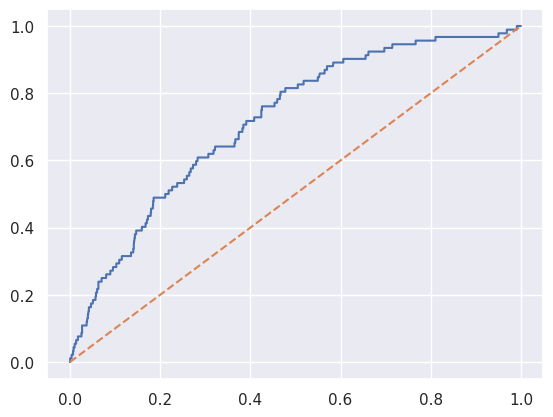

f1 score: 0.11914893617021277


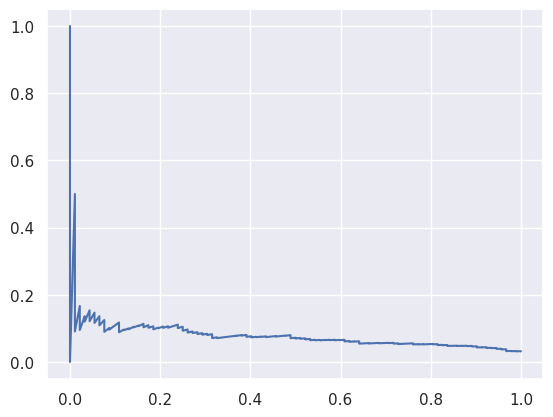

[[2001  792]
 [  36   56]]
accuracy: 0.7129982668977469
balanced accuracy: 0.6625647970858825
sensitivity: 0.6086956521739131
specificity: 0.0660377358490566
precision: 0.0660377358490566
recall: 0.6086956521739131


In [53]:
# all_metrics(report_d3)
df = report_d3.loc[report_d3['duration'] == '3']
all_metrics(df)

AUROC: 0.8338013419597108


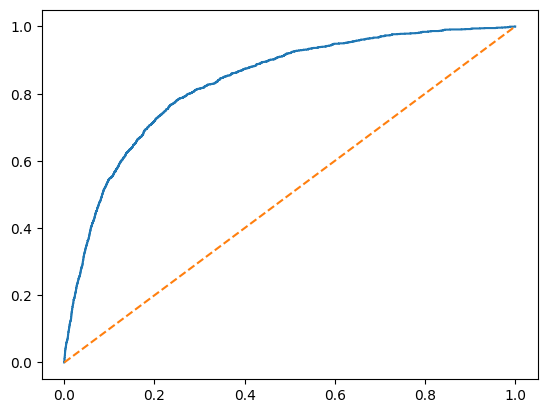

f1 score: 0.32980034508257333


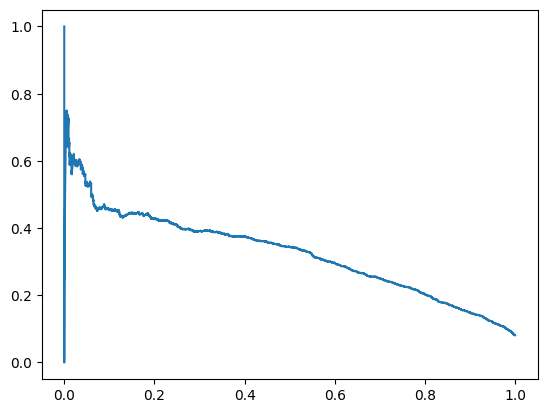

[[14078  5083]
 [  355  1338]]
accuracy: 0.7392346791982354
balanced accuracy: 0.762517311803087
sensitivity: 0.7903130537507383
specificity: 0.2083787572029279
precision: 0.2083787572029279
recall: 0.7903130537507383


In [27]:
all_metrics(report_d4)

AUROC: 0.828627656993379


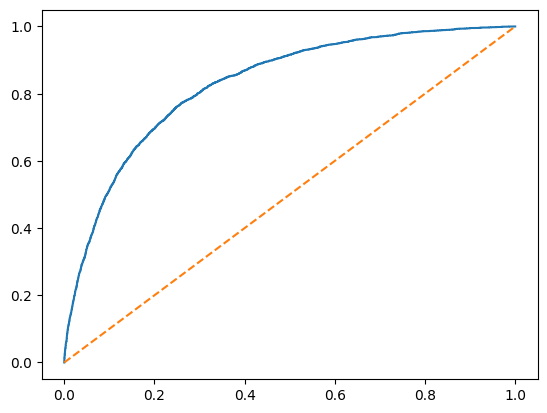

f1 score: 0.5442010646653286


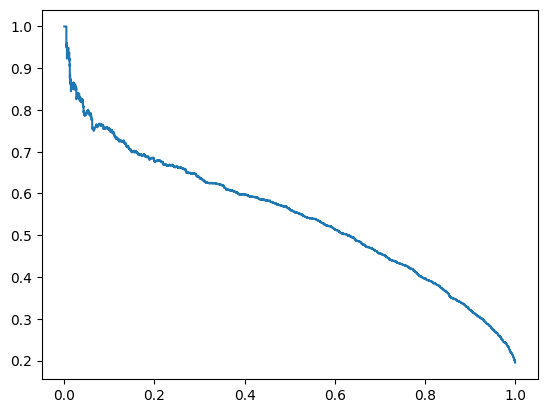

[[12513  4268]
 [  955  3118]]
accuracy: 0.7495444519037116
balanced accuracy: 0.7555969169591374
sensitivity: 0.7655290940338817
specificity: 0.42215001353912807
precision: 0.42215001353912807
recall: 0.7655290940338817


In [28]:
all_metrics(report_d5)

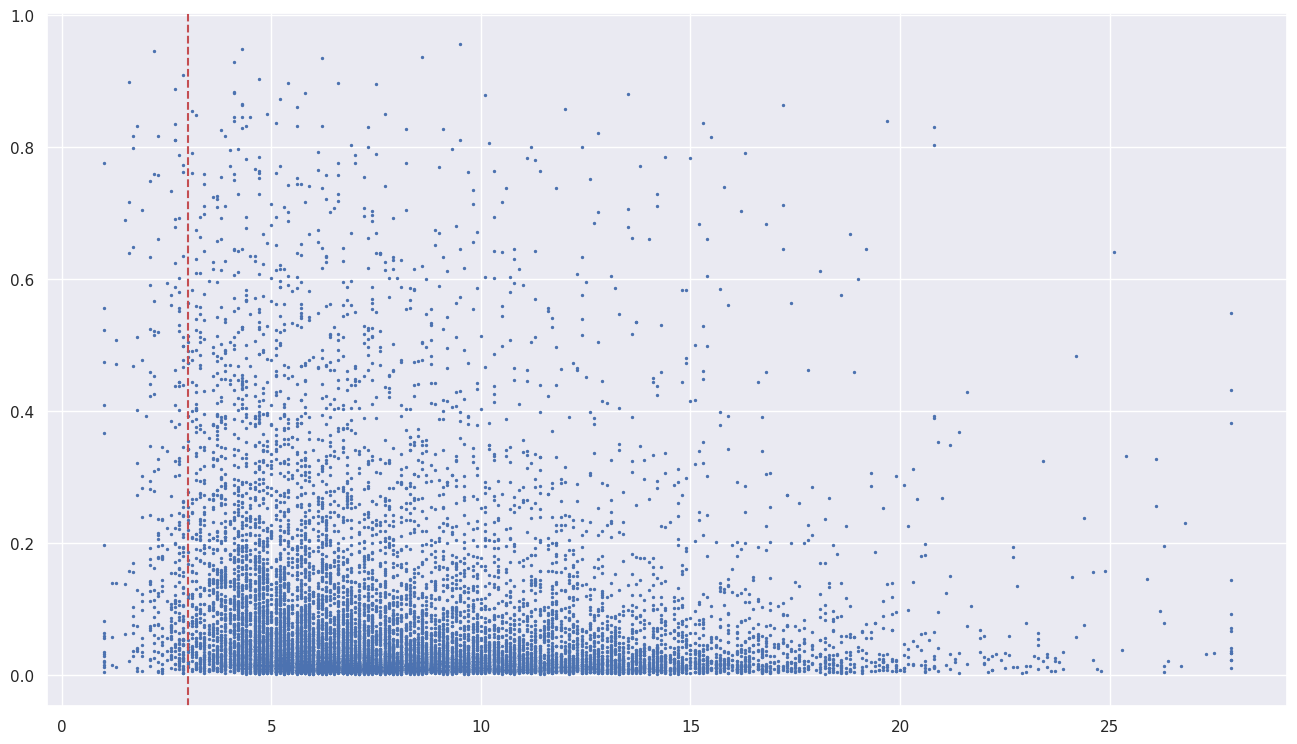

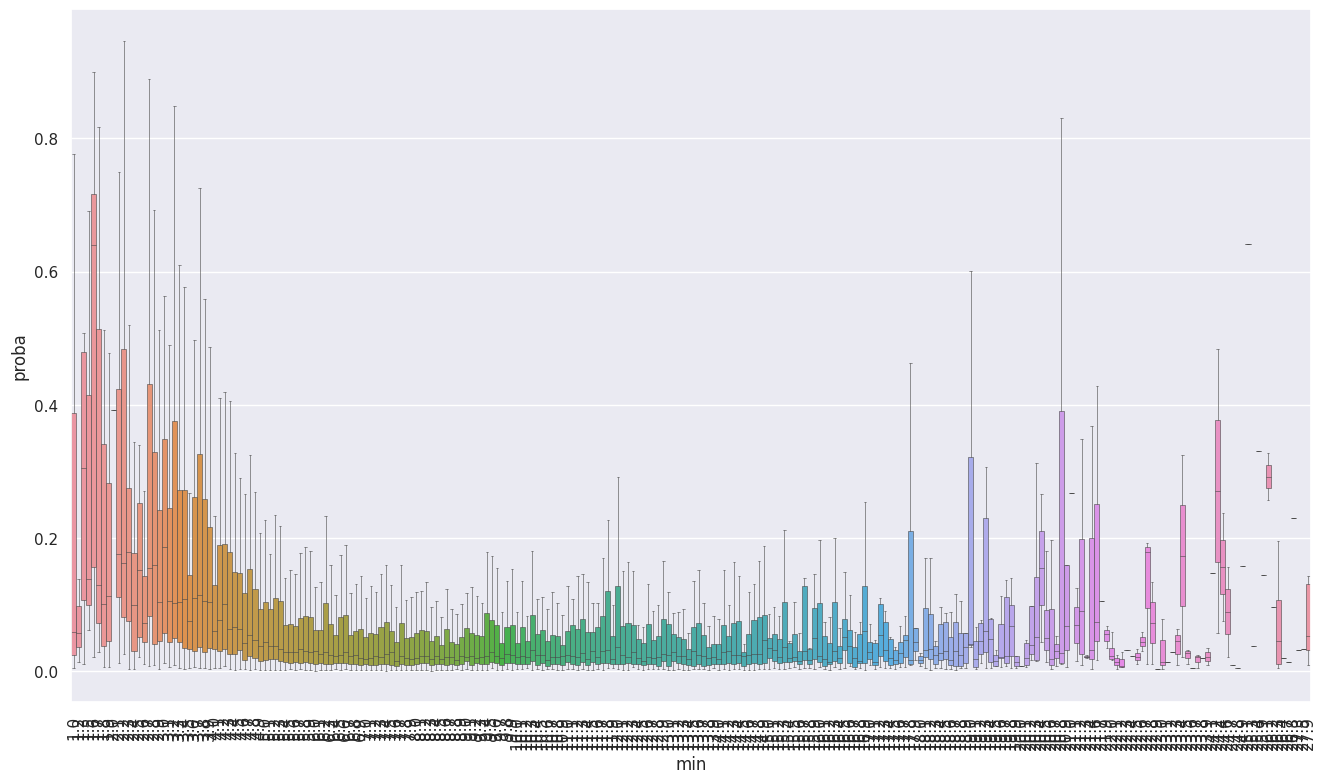

In [55]:
df = report_d3
#df = df.loc[df['duration'] == '4']

# plot scatter plot of predicted probability vs actual glucose
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,9))
# colour points according to ground truth, red = 1, blue = 0
#ax.scatter(df['min'], df['proba'], c=df['ground_truth'], s=2)
#plt.show()
# verticval line at threshold
plt.axvline(x=3, color='r', linestyle='--')
plt.scatter(df['min'], df['proba'], s=2)
plt.show()

# plot boxplot of predicted probability for each glucose value
import seaborn as sns
fig, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=df['min'], y=df['proba'], width = 1, showfliers = False, linewidth=0.4)
ax.tick_params(axis='x', rotation=90)
plt.show()

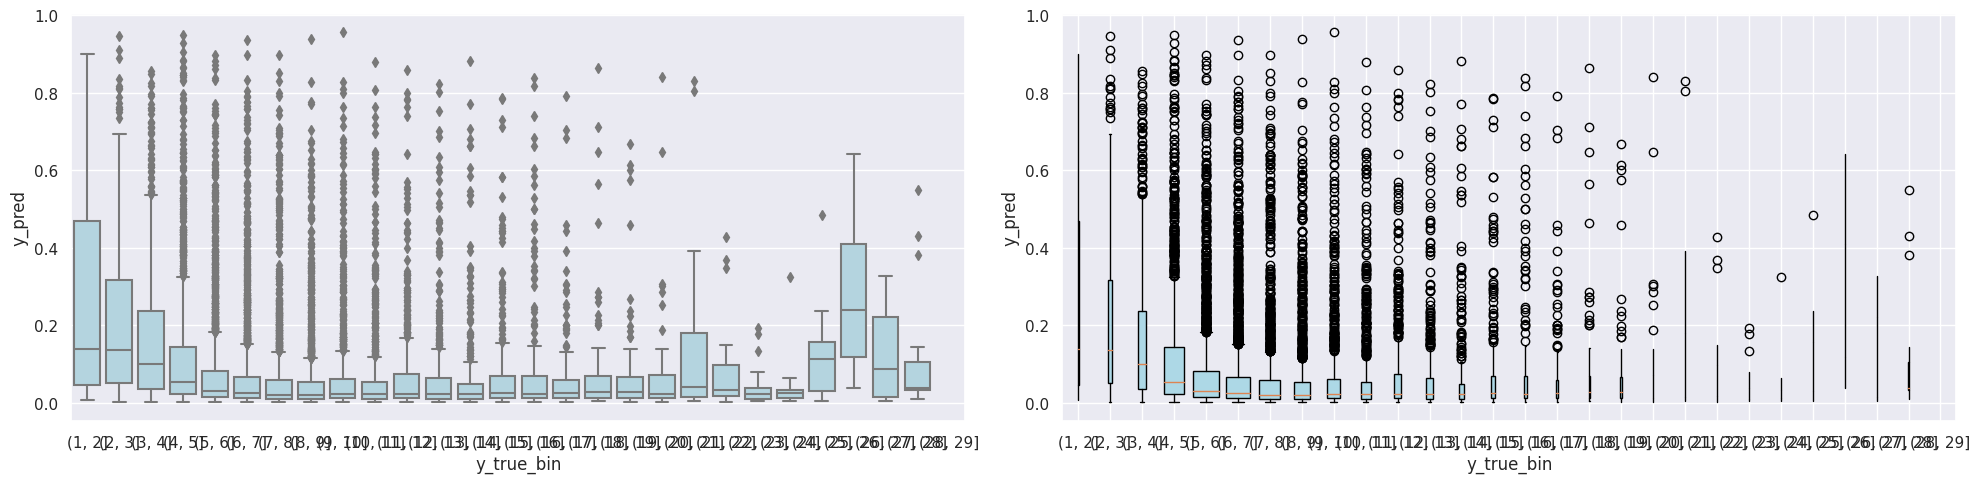

In [56]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

df = report_d3

y_true = np.asarray(df['min'])
y_pred = np.asarray(df['proba'])
df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
df['y_true_bin'] = pd.cut(df['y_true'], np.arange(1, 30, 1))

sns.set()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
sns.boxplot(x='y_true_bin', y='y_pred', data=df, color='lightblue', ax=ax1)

bins, groups = zip(*df.groupby('y_true_bin')['y_pred'])
lengths = np.array([len(group) for group in groups])
max_width = 0.8
ax2.boxplot(groups, widths=max_width * lengths / lengths.max(),
patch_artist=True, boxprops={'facecolor': 'lightblue'})
ax2.set_xticklabels(bins)
ax2.set_xlabel('y_true_bin')
ax2.set_ylabel('y_pred')
plt.tight_layout()
plt.show()